# Loan Approval Decision Support Analysis

## Objective

The objective of this analysis is to evaluate how different classification models can support loan approval decisions by balancing predictive performance, interpretability, and financial risk. Rather than optimizing for accuracy alone, the focus is on understanding model tradeoffs and how decision thresholds can be adjusted to align predictions with real-world business and risk considerations.


## Context
Loan approval decisions involve tradeoffs between approving qualified applicants and minimizing default risk. In practice, predictive models are often used as decision-support tools to flag applications for approval or manual review rather than as fully automated systems.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Data Overview
The dataset contains historical loan application records with applicant demographic, financial, and loan-related features. The target variable indicates whether a loan was approved or rejected.

Prior to modeling, the data was reviewed for missing values, categorical variables were encoded, and features were prepared for use in classification models.

The target variable is moderately imbalanced, which is important to consider when interpreting model performance.

In [35]:
df = pd.read_csv('data/Loan-Approval-Prediction.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [36]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    str    
 1   Gender             601 non-null    str    
 2   Married            611 non-null    str    
 3   Dependents         599 non-null    str    
 4   Education          614 non-null    str    
 5   Self_Employed      582 non-null    str    
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    str    
 12  Loan_Status        614 non-null    str    
dtypes: float64(4), int64(1), str(8)
memory usage: 62.5 KB


The dataset contains 480 records with a mix of numeric and categorical features relevant to loan approval decisions.

<Axes: xlabel='Loan_Status'>

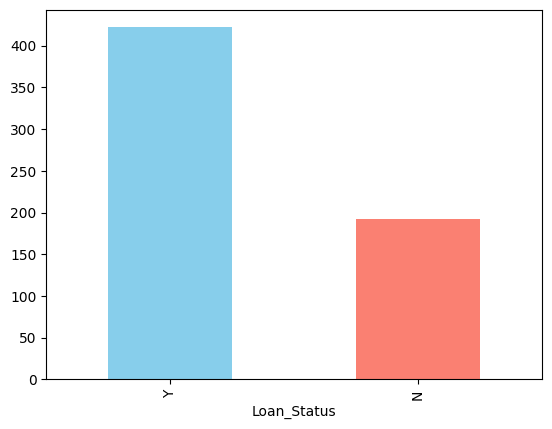

In [37]:
df['Loan_Status'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

## Data Preparation
To prepare the data for modeling, missing values were handled and categorical variables were encoded. The dataset was then split into input features (X) and the target variable (y) to ensure models only used information available at the time of the loan decision.


In [38]:
df['Loan_Status'] = df.Loan_Status.replace('N', 0).replace('Y',1).astype(int)
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Married'] = df['Married'].map({'No': 0, 'Yes': 1})
df['Self_Employed'] = df['Self_Employed'].map({'No': 0, 'Yes': 1})
df['Education'] = df.Education.replace('Not Graduate', 0).replace('Graduate',1).astype(int)
df['Dependents'] = df['Dependents'].map({'0': 0, '1': 1, '2': 2, '3+': 3})
df['Property_Area'] = df.Property_Area.replace('Rural', 0).replace('Semiurban',1).replace('Urban',2).astype(int)

df = df.dropna()

df = df[df['ApplicantIncome'] <= 30000]

In [39]:
X = df.drop(columns=["Loan_Status", "Loan_ID"])
y = df["Loan_Status"]

In [40]:
rs=123

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=rs
    )

## Modeling and Evaluation
Multiple classification models were evaluated to assess their suitability for supporting loan approval decisions. Rather than focusing solely on overall accuracy, evaluation emphasized class-specific performance metrics and error tradeoffs relevant to financial risk.


### Logistic Regression
Logistic regression was used as a baseline model due to its interpretability and common use in credit decisioning.


In [41]:
lr = LogisticRegression(random_state=rs,
                            penalty='l2',
                            solver='lbfgs',
                            max_iter=1000)
lr.fit(X_train, y_train)

/Users/abbyblas/Downloads/Projects/loan-approval-risk-analysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/abbyblas/Downloads/Projects/loan-approval-risk-analysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",123
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` 

In [42]:
lr_preds = lr.predict(X_test)
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.73      0.38      0.50        29
           1       0.78      0.94      0.85        66

    accuracy                           0.77        95
   macro avg       0.75      0.66      0.67        95
weighted avg       0.76      0.77      0.74        95



In [43]:
confusion_matrix(y_test, lr_preds)

array([[11, 18],
       [ 4, 62]])

**Interpretation**

The logistic regression model prioritized approving qualified applicants, resulting in fewer false rejections but a higher number of false approvals. While this approach may support higher approval rates, it also introduces increased financial risk.


### Random Forest Classifier

A Random Forest model was evaluated to compare performance against logistic regression. While less interpretable, tree-based models can capture non-linear relationships and interactions between features, which may improve predictive performance in complex decision settings.

In [44]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=rs
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [45]:
rf_preds = rf.predict(X_test)

print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.65      0.45      0.53        29
           1       0.79      0.89      0.84        66

    accuracy                           0.76        95
   macro avg       0.72      0.67      0.68        95
weighted avg       0.74      0.76      0.74        95



In [46]:
confusion_matrix(y_test, rf_preds)

array([[13, 16],
       [ 7, 59]])

**Interpretation**

The Random Forest model reduced false approvals compared to logistic regression, indicating improved risk control. However, this came at the cost of increased false rejections.

### Model Comparison and Risk Tradeoffs

The logistic regression model favored approval rates and minimized false rejections, while the Random Forest model adopted a more conservative risk posture by reducing false approvals. Model selection should therefore be guided by organizational risk tolerance rather than overall accuracy alone.

This tradeoff reflects different risk postures: logistic regression may be suitable in scenarios prioritizing approval rates and customer experience, while the Random Forest model may better align with risk-averse lending strategies focused on minimizing financial loss.


## Cost-Sensitive Decision Threshold Analysis
Real-world loan approval decisions require explicit consideration of the costs associated with different types of errors. In particular, false approvals often carry greater financial risk than false rejections. This section evaluates how adjusting the decision threshold influences approval rates and cost tradeoffs, reframing model predictions as decision-support tools.

In [47]:
lr_probs = lr.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]

In [48]:
def evaluate_thresholds(y_true, y_probs, thresholds, cost_fp=5, cost_fn=1):
    results = []

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        total_cost = (fp * cost_fp) + (fn * cost_fn)
        approval_rate = (tp + fp) / len(y_true)

        results.append({
            "Threshold": t,
            "False Approvals (FP)": fp,
            "False Rejections (FN)": fn,
            "Approval Rate": approval_rate,
            "Estimated Cost": total_cost
        })

    return pd.DataFrame(results)


In [49]:
thresholds = [0.3, 0.4, 0.5, 0.6]

lr_results = evaluate_thresholds(y_test, lr_probs, thresholds)
rf_results = evaluate_thresholds(y_test, rf_probs, thresholds)

In [50]:
lr_results.sort_values("Estimated Cost")

,Threshold,False Approvals (FP),False Rejections (FN),Approval Rate,Estimated Cost
0,0.3,18,4,0.842105,94
1,0.4,18,4,0.842105,94
2,0.5,18,4,0.842105,94
3,0.6,18,6,0.821053,96


Adjusting the decision threshold for logistic regression provides limited risk reduction while negatively impacting approval rates, suggesting the model has limited flexibility as a decision-support tool in this range.

In [51]:
rf_results.sort_values("Estimated Cost")

,Threshold,False Approvals (FP),False Rejections (FN),Approval Rate,Estimated Cost
3,0.6,15,12,0.726316,87
2,0.5,16,7,0.789474,87
1,0.4,17,4,0.831579,89
0,0.3,18,4,0.842105,94


The Random Forest model allows for more precise control over approval risk through threshold tuning, enabling organizations to reduce false approvals at the expense of stricter approval criteria.

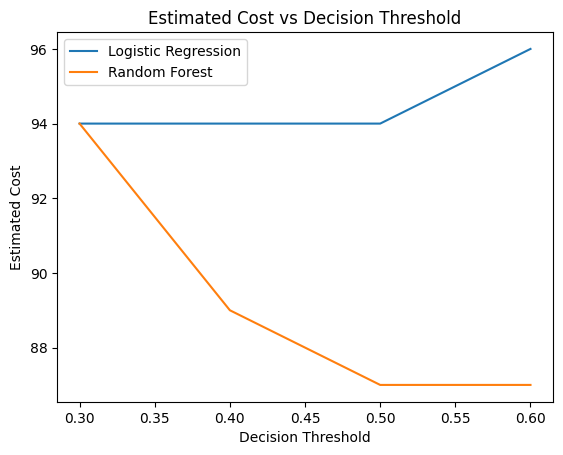

In [52]:
plt.figure()
plt.plot(lr_results["Threshold"], lr_results["Estimated Cost"], label= "Logistic Regression")
plt.plot(rf_results["Threshold"], rf_results["Estimated Cost"], label="Random Forest")
plt.xlabel("Decision Threshold")
plt.ylabel("Estimated Cost")
plt.title("Estimated Cost vs Decision Threshold")
plt.legend()
plt.show()

The plot illustrates how estimated decision cost changes as approval thresholds become more conservative, highlighting differences in risk sensitivity between models.

### Interpretation

The cost-sensitive threshold analysis reveals meaningful differences in how each model supports decision-making. Logistic regression shows minimal sensitivity to threshold changes, with false approvals and estimated cost remaining largely unchanged across a wide range of thresholds. This suggests limited flexibility in managing risk through decision rules alone.

In contrast, the Random Forest model responds strongly to threshold adjustments. Increasing the threshold reduces false approvals and overall estimated cost, but at the expense of rejecting more qualified applicants and lowering approval rates. This highlights a clear tradeoff between financial risk control and customer access.

These results demonstrate how model choice and decision thresholds jointly influence approval outcomes, reinforcing the role of predictive models as adjustable decision-support tools rather than fully automated systems.

## Practical Application

This analysis demonstrates how predictive models can be used to support, rather than automate, loan approval decisions. By adjusting decision thresholds based on the relative cost of false approvals and false rejections, institutions can align model outputs with their risk tolerance and business priorities. In practice, such models could be used to flag higher-risk applications for additional review while allowing lower-risk applications to proceed through standard approval workflows.